In [1]:
import sys
sys.path.append('/Users/lindsaybassman/Documents/LBL/ArQTiC')
from arqtic.simulation_generator import Simulation_Generator
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
from qiskit import Aer, IBMQ, execute
import random

In [12]:
#create simulation object
sim_obj = Simulation_Generator("QITE_input.txt")

#Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
#setup inital hamiltonian

#number of samples
T = 1000
nmetts = T+10
#number of qubits
N = sim_obj.num_spins
#size of matrix
msize = 2**N
#Hamiltonian parameters
Jz = sim_obj.Jz #ising interaction strength
mu_x = sim_obj.h_ext #transverse magnetic field strength
#initial Hamiltonian
hinit = np.zeros((msize, msize), dtype=np.complex128)
#2qubits
#hinit += Jz*np.kron(sz,sz)
#hinit += mu_x*np.kron(sx,np.eye(2))
#hinit += mu_x*np.kron(np.eye(2),sx)
#3qubits
hinit += Jz*np.kron(np.eye(2), np.kron(sz, sz))
hinit += Jz*np.kron(sz, np.kron(sz, np.eye(2)))
hinit += mu_x*np.kron(np.eye(2), np.kron(np.eye(2), sx))
hinit += mu_x*np.kron(np.eye(2), np.kron(sx,np.eye(2)))
hinit += mu_x*np.kron(sx, np.kron(np.eye(2), np.eye(2)))


#Quantum METTS
#set up simulators
qasm_sim = Aer.get_backend('qasm_simulator')
state_vector_sim = Aer.get_backend('statevector_simulator')

#get random first product state for METTS
measured_metts_state = []
for _ in range(N):
    measured_metts_state.append(str(random.choice([0,1])))
    
#for METTS we want to evolve by beta/2 for system at temperature beta
sim_obj.beta = sim_obj.beta/2.0
#loop over trajectories
eng_array = []
q_regs = qk.QuantumRegister(N, 'q')
c_regs = qk.ClassicalRegister(N, 'c')
for i in range(nmetts):
    if (i%100 == 0):
        print(i)
    #set initial product state
    #print(measured_metts_state)
    sim_obj.initial_spins = measured_metts_state
    sim_obj.generate_programs()
    qite_circ = sim_obj.ibm_circuits_list[0]
    #print(qite_circ)
    #get next METTS
    QMETTS_circ = qk.QuantumCircuit(q_regs, c_regs)
    QMETTS_circ.compose(qite_circ, qubits=q_regs, inplace=True)
    if (i%2 == 0):
        QMETTS_circ.h(q_regs)
    QMETTS_circ.measure(q_regs, c_regs)
    result = qk.execute(QMETTS_circ, qasm_sim, shots=1).result().get_counts()
    #update measured metts state for next trajectory
    for spin_str, count in result.items():
        measured_metts_state[2] = spin_str[0]
        measured_metts_state[1] = spin_str[1]
        measured_metts_state[0] = spin_str[2]
    #get energy
    result = qk.execute(qite_circ, state_vector_sim).result()
    statevector = result.get_statevector(qite_circ)
    eng = np.real(np.dot(np.conj(statevector).transpose(), np.dot(hinit, statevector)))
    eng_array.append(eng)

0
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating I

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM quantum circuit objects...
IBM quantum circuit objects created
Creating IBM

In [10]:
#without basis swap
for t in [100, 250, 500, 750, 1000]:
    print(np.mean(eng_array[10:10+t]))

-2.689555738803267
-2.7180721115482473
-2.7643123869435104
-2.782956500210456
-2.7816188233522428


In [14]:
#with basis swap
for t in [100, 250, 500, 750, 1000]:
    print(np.mean(eng_array[10:10+t]))

-2.687122784543072
-2.6698546702848662
-2.6627666929877987
-2.6685969024036913
-2.667176952406965


In [11]:
no_basis_swap_eng = eng_array
print(no_basis_swap_eng)

[-3.0277969447338515, -3.0277969447338515, -3.0277969447338515, -2.422861002577806, -2.427380142060748, -2.425774367615209, -2.4247242209696975, -2.425774367615209, -3.0285437084543134, -3.0285437084543134, -2.4247242209696975, -2.425774367615209, -2.427380142060748, -2.422861002577806, -2.427380142060748, -2.422861002577806, -2.427380142060748, -2.422861002577806, -2.427380142060748, -2.422861002577806, -3.0277969447338515, -3.0277969447338515, -3.0277969447338515, -3.0277969447338515, -3.0277969447338515, -2.427380142060748, -2.422861002577806, -2.427380142060748, -2.422861002577806, -2.4247242209696975, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -2.425774367615209, -2.4247242209696975, -2.425774367615209, -2.425774367615209, -2.4247242209696975, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -3.0285437084543134, -2.425774367615209, -2.4247242209696975, -2.422861002577806, -2.4247242209

In [15]:
with_basis_swap_eng = eng_array
print(with_basis_swap_eng)

[-3.0277969447338515, -3.0285437084543134, -3.0285437084543134, -2.427380142060748, -2.422861002577806, -2.631489161196029, -3.0285437084543134, -2.631489161196029, -2.631489161196029, -2.631489161196029, -2.631489161196029, -2.4247242209696975, -2.425774367615209, -2.631489161196029, -2.631489161196029, -2.4247242209696975, -2.5941622312587724, -2.631489161196029, -3.0285437084543134, -2.5941622312587724, -3.0277969447338515, -3.0285437084543134, -3.0285437084543134, -2.631489161196029, -2.427380142060748, -2.631489161196029, -2.422861002577806, -2.4247242209696975, -2.425774367615209, -2.631489161196029, -3.0285437084543134, -2.631489161196029, -2.631489161196029, -2.631489161196029, -3.0285437084543134, -3.0285437084543134, -2.631489161196029, -2.427380142060748, -3.0277969447338515, -2.631489161196029, -2.631489161196029, -2.631489161196029, -2.427380142060748, -2.631489161196029, -3.0285437084543134, -2.631489161196029, -3.0285437084543134, -2.631489161196029, -2.4247242209696975,

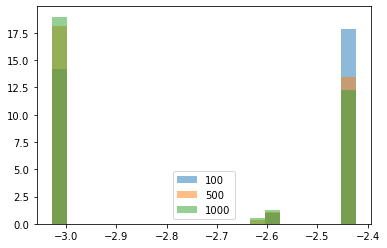

In [21]:
bins = 20
plt.hist(no_basis_swap_eng[10:110], bins, label="100", alpha=0.5, density=True)
plt.hist(no_basis_swap_eng[10:510], bins, label="500", alpha=0.5, density=True)
plt.hist(no_basis_swap_eng[10:1010], bins, label="1000", alpha=0.5, density=True)
plt.legend()
plt.show()

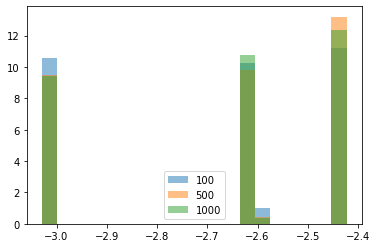

In [20]:
bins = 20
plt.hist(with_basis_swap_eng[10:110], bins, label="100", alpha=0.5, density=True)
plt.hist(with_basis_swap_eng[10:510], bins, label="500", alpha=0.5, density=True)
plt.hist(with_basis_swap_eng[10:1010], bins, label="1000", alpha=0.5, density=True)
plt.legend()
plt.show()